## Observations and Insights 

In [1]:
# Observations

# 1. This source Data is well balanced date interms of 3 points below.
#  > Datapoints for each medicines (See "Bar and Pie Charts", everything around 150~250),
#  > Sex Ratio (See "Bar and Pie Charts", Male:Female = 51:49, nearly 1:1)
#  > Quality of the data could be considered good. 4x promising medicine, 100 datapoints, only 1 outlier.

# 2. Based on 1st observation, we might able to evaluate effectiveness of 4x promising medicines.
#  > Example of "l509" (in "Line and Scatter Plots") shows that dcrease trend of tumor volume.
#  > This suggest that by plotting these lines per mouse, per medicines, we could evaluate the effectieness in group.
#  > However, we couldn't use the scatter plot in this case since it has to focus on timelapse dceasing trend.

# 3. "Average weight throught the test period" vs "Tumor Volume" shows clear correlation.
#  > It's sounds quite reasonable that the more weight of the mouse, the more volume of tumor.
#  > Taking into account this clear correlation, it might be an opition 
#    to weight the data by mouse average weight throught the test period.
#    (Divide tumore volume by average weight of the mouse through the period)
#  > By that, we could focus on decrease in tumor volume regardless the mouse weight.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path) #249
study_results = pd.read_csv(study_results_path) #1893

# Combine the data into a single dataset
combined_mouse_data = pd.merge(study_results, mouse_metadata,
                               how="outer", on="Mouse ID")

# Display the data table for preview
combined_mouse_data.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22


In [3]:
# Checking the number of mice.
print(combined_mouse_data["Mouse ID"].nunique())


249


In [4]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
duplicated_data = combined_mouse_data[
    combined_mouse_data.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)]

print(duplicated_data["Mouse ID"].unique())

['g989']


In [5]:
# Optional: Get all the data for the duplicate mouse ID. 
g989_data = combined_mouse_data.loc[combined_mouse_data["Mouse ID"] == "g989", :]
g989_data

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.000000,0,Propriva,Female,21,26
861,g989,0,45.000000,0,Propriva,Female,21,26
862,g989,5,48.786801,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
864,g989,10,51.745156,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
866,g989,15,51.325852,1,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
868,g989,20,55.326122,1,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.

# In previous Process, it's been identified that "g989" is the only duplicating ID.
# In clean data, all data related to "g989" has to be deleted.

clean_data = combined_mouse_data[combined_mouse_data["Mouse ID"]!= "g989"]
clean_data.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22


In [7]:
# Checking the number of mice in the clean DataFrame.
clean_data["Mouse ID"].nunique()


248

## Summary Statistics

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen

# This method is the most straighforward, creating multiple series and putting them all together at the end.

drug_regi_clean_data = clean_data.groupby("Drug Regimen")

mean_tv   = drug_regi_clean_data["Tumor Volume (mm3)"].mean()
median_tv = drug_regi_clean_data["Tumor Volume (mm3)"].median()
var_tv    = drug_regi_clean_data["Tumor Volume (mm3)"].var()
std_tv    = drug_regi_clean_data["Tumor Volume (mm3)"].std()
sem_tv    = drug_regi_clean_data["Tumor Volume (mm3)"].sem()

tv_summary_data_1 = pd.DataFrame({"Mean Tumor Volume": mean_tv,
                                "Median Tumor Volume": median_tv,
                                "Tumor Volume Variance": var_tv,
                                "Tumor Volume Std. Dev.": std_tv,
                                "Tumor Volume Std. Err.": sem_tv})
                                
tv_summary_data_1

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [9]:
# Generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen

# This method produces everything in a single groupby function
tv_summary_data_2 = drug_regi_clean_data.agg({"Tumor Volume (mm3)":["mean","median","var","std","sem"]})

tv_summary_data_2

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

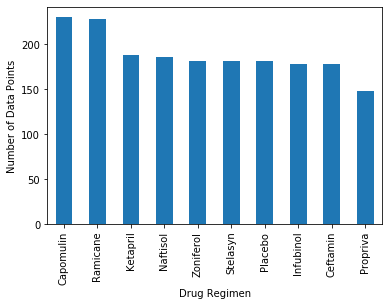

In [10]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas. 
dr_count = drug_regi_clean_data["Drug Regimen"].count().sort_values(ascending=False)

dr_count_chart = dr_count.plot(kind="bar")
dr_count_chart.set_xlabel("Drug Regimen")
dr_count_chart.set_ylabel("Number of Data Points")

plt.show()

Text(0, 0.5, 'Number of Data Points')

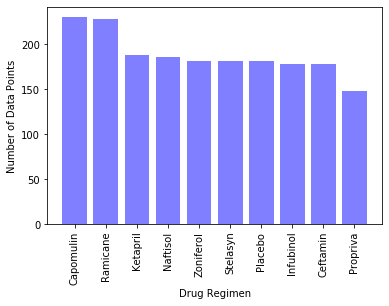

In [11]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.

x_axis = np.arange(len(dr_count))
tick_regimen = [value for value in x_axis]
plt.bar(x_axis, dr_count, color="b", alpha=0.5, align="center")
plt.xticks(tick_regimen, dr_count.index, rotation="vertical")

plt.xlabel("Drug Regimen")
plt.ylabel("Number of Data Points")

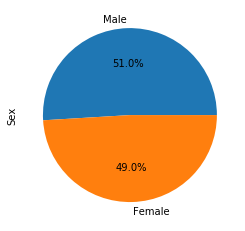

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

sex_clean_data = clean_data.groupby("Sex")
sex_count = sex_clean_data["Sex"].count().sort_values(ascending=False)
sex_count_chart = sex_count.plot(kind="pie", autopct="%1.1f%%")

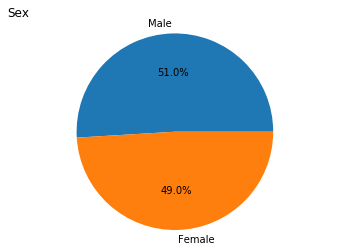

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

pies = sex_count.index
pie_votes = sex_count
plt.pie(pie_votes, labels=pies, autopct="%1.1f%%")
plt.title("Sex", loc="left", )
plt.axis("equal")
plt.show()

## Quartiles, Outliers and Boxplots

In [14]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint


# Capomulin
cap_data = clean_data.loc[(clean_data["Drug Regimen"] == "Capomulin"), :]
cap_max_data = cap_data.loc[cap_data.groupby("Mouse ID")["Timepoint"].idxmax(), :]
cap_max_data = cap_max_data.loc[:, ["Mouse ID", "Timepoint", "Tumor Volume (mm3)"]]

# Ramicane
ram_data = clean_data.loc[(clean_data["Drug Regimen"] == "Ramicane"), :]
ram_max_data = ram_data.loc[ram_data.groupby("Mouse ID")["Timepoint"].idxmax(), :]
ram_max_data = ram_max_data.loc[:, ["Mouse ID", "Timepoint", "Tumor Volume (mm3)"]]

# Infubinol
inf_data = clean_data.loc[(clean_data["Drug Regimen"] == "Infubinol"), :]
inf_max_data = inf_data.loc[inf_data.groupby("Mouse ID")["Timepoint"].idxmax(), :]
inf_max_data = inf_max_data.loc[:, ["Mouse ID", "Timepoint", "Tumor Volume (mm3)"]]

# Ceftamin
cef_data = clean_data.loc[(clean_data["Drug Regimen"] == "Ceftamin"), :]
cef_max_data = cef_data.loc[cef_data.groupby("Mouse ID")["Timepoint"].idxmax(), :]
cef_max_data = cef_max_data.loc[:, ["Mouse ID", "Timepoint", "Tumor Volume (mm3)"]]


In [15]:
# Put treatments into a list for for loop (and later for plot labels)

# Create empty list to fill with tumor vol data (for plotting)

# Capomulin
cap_tv_clean = []
cap_tv_outlier = []

# Ramicane
ram_tv_clean = []
ram_tv_outlier = []

# Infubinol
inf_tv_clean = []
inf_tv_outlier = []

# Ceftamin
cef_tv_clean = []
cef_tv_outlier = []


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

# Locate the rows which contain mice on each drug and get the tumor volumes
        
    # add subset 
        
    # Determine outliers using upper and lower bounds

# Capomulin
cap_tv_data   = cap_max_data["Tumor Volume (mm3)"]
cap_quartiles = cap_tv_data.quantile([.25,.5,.75])
cap_lowerq = cap_quartiles[0.25]
cap_upperq = cap_quartiles[0.75]
cap_iqr = cap_upperq-cap_lowerq
cap_lower_bound = cap_lowerq - (1.5*cap_iqr)
cap_upper_bound = cap_upperq + (1.5*cap_iqr)

for tv in cap_tv_data:
    if tv >= cap_lower_bound and tv <= cap_upper_bound :
        cap_tv_clean.append(tv)
    else:
        cap_tv_outlier.append(tv)

cap_count_outlier = len(cap_tv_outlier)
cap_total_dp = len(cap_tv_clean) + len(cap_tv_outlier)
print(f"[Capomulin] Potential outliers count: {cap_count_outlier}, Total Data Point: {cap_total_dp}")


# Ramicane
ram_tv_data   = ram_max_data["Tumor Volume (mm3)"]
ram_quartiles = ram_tv_data.quantile([.25,.5,.75])
ram_lowerq = ram_quartiles[0.25]
ram_upperq = ram_quartiles[0.75]
ram_iqr = ram_upperq-ram_lowerq
ram_lower_bound = ram_lowerq - (1.5*ram_iqr)
ram_upper_bound = ram_upperq + (1.5*ram_iqr)

for tv in ram_tv_data:
    if tv >= ram_lower_bound and tv <= ram_upper_bound :
        ram_tv_clean.append(tv)
    else:
        ram_tv_outlier.append(tv)

ram_count_outlier = len(ram_tv_outlier)
ram_total_dp = len(ram_tv_clean) + len(ram_tv_outlier)
print(f"[Ramicane] Potential outliers count: {ram_count_outlier}, Total Data Point: {ram_total_dp}")


# Infubinol
inf_tv_data   = inf_max_data["Tumor Volume (mm3)"]
inf_quartiles = inf_tv_data.quantile([.25,.5,.75])
inf_lowerq = inf_quartiles[0.25]
inf_upperq = inf_quartiles[0.75]
inf_iqr = inf_upperq-inf_lowerq
inf_lower_bound = inf_lowerq - (1.5*inf_iqr)
inf_upper_bound = inf_upperq + (1.5*inf_iqr)

for tv in inf_tv_data:
    if tv >= inf_lower_bound and tv <= inf_upper_bound :
        inf_tv_clean.append(tv)
    else:
        inf_tv_outlier.append(tv)

inf_count_outlier = len(inf_tv_outlier)
inf_total_dp = len(inf_tv_clean) + len(inf_tv_outlier)
print(f"[Infubinol] Potential outliers count: {inf_count_outlier}, Total Data Point: {inf_total_dp}")


# Ceftamin
cef_tv_data   = cef_max_data["Tumor Volume (mm3)"]
cef_quartiles = cef_tv_data.quantile([.25,.5,.75])
cef_lowerq = cef_quartiles[0.25]
cef_upperq = cef_quartiles[0.75]
cef_iqr = cef_upperq-cef_lowerq
cef_lower_bound = cef_lowerq - (1.5*cef_iqr)
cef_upper_bound = cef_upperq + (1.5*cef_iqr)

for tv in cef_tv_data:
    if tv >= cef_lower_bound and tv <= cef_upper_bound :
        cef_tv_clean.append(tv)
    else:
        cef_tv_outlier.append(tv)

cef_count_outlier = len(cef_tv_outlier)
cef_total_dp = len(cef_tv_clean) + len(cef_tv_outlier)
print(f"[Capomulin] Potential outliers count: {cef_count_outlier}, Total Data Point: {cef_total_dp}")


[Capomulin] Potential outliers count: 0, Total Data Point: 25
[Ramicane] Potential outliers count: 0, Total Data Point: 25
[Infubinol] Potential outliers count: 1, Total Data Point: 25
[Capomulin] Potential outliers count: 0, Total Data Point: 25


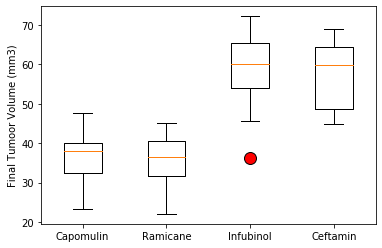

In [16]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

tv_box_data = (cap_tv_data, ram_tv_data, inf_tv_data, cef_tv_data)

red_circle = dict(markerfacecolor="r", marker="o", markersize=12)
fig1, ax1 = plt.subplots()
ax1.set_xticklabels(["Capomulin", "Ramicane", "Infubinol", "Ceftamin"])
ax1.set_ylabel('Final Tumoor Volume (mm3)')
ax1.boxplot(tv_box_data, flierprops=red_circle)
plt.show()

## Line and Scatter Plots

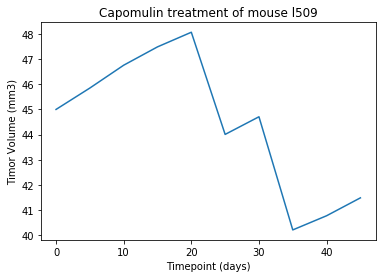

In [17]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin

# Prep Dataframe for "Drug Regimen: Capomulin" & "Mouse ID: l509"
capomulin_l509_data = clean_data.loc[(clean_data["Drug Regimen"] == "Capomulin"), :]
capomulin_l509_data = clean_data.loc[(clean_data["Mouse ID"] == "l509"), :]

timepoints = capomulin_l509_data["Timepoint"]
tv_capomulin_l509 = capomulin_l509_data["Tumor Volume (mm3)"]
capomulin_l509 = plt.plot(timepoints, tv_capomulin_l509)

plt.title("Capomulin treatment of mouse l509")
plt.xlabel("Timepoint (days)")
plt.ylabel("Timor Volume (mm3)")

plt.show()

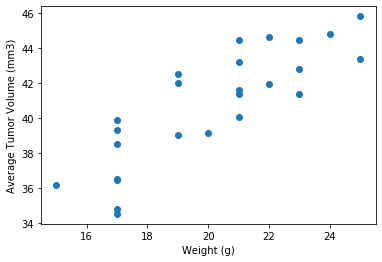

In [18]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
capomulin_data = clean_data.loc[(clean_data["Drug Regimen"] == "Capomulin"), :]
capomulin_mean_data = capomulin_data.groupby("Mouse ID")

mean_tv_cap = capomulin_mean_data["Tumor Volume (mm3)"].mean()
mean_w_cap = capomulin_mean_data["Weight (g)"].mean()

cap_mean_summary = pd.DataFrame({"Average Tumor Volume (mm3)": mean_tv_cap,
                                 "Weight (g)": mean_w_cap})

x_values = cap_mean_summary["Weight (g)"]
y_values = cap_mean_summary["Average Tumor Volume (mm3)"]
plt.scatter(x_values, y_values)
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()

## Correlation and Regression

The correlation between mouse weight and the average tumor volume is 0.84.


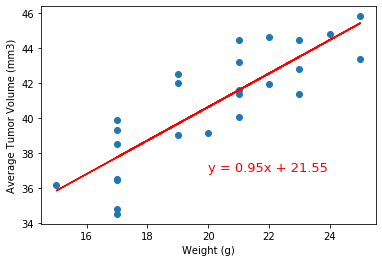

In [19]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
x_values = cap_mean_summary["Weight (g)"]
y_values = cap_mean_summary["Average Tumor Volume (mm3)"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,37),fontsize=13,color="red")
rvalue_round = round(rvalue,2)

plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
print(f"The correlation between mouse weight and the average tumor volume is {rvalue_round}.")
plt.show()